In [20]:
import numpy as np
import pandas as pd
import torch
import zipfile
import bz2
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Data

## 1. Twitter

In [5]:
data_path = "../data/"

In [105]:
twitter_zip = zipfile.ZipFile(data_path + "twitter/twitter.zip")
twitter = pd.read_csv(twitter_zip.open('training.1600000.processed.noemoticon.csv'),encoding='ISO-8859-1', header=None)
twitter.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [82]:
y_tw = twitter[0].values
y_tw[y_tw==4]=1
X_tw = twitter[5].values

X_train_val_tw, X_test_tw, y_train_val_tw, y_test_tw = train_test_split(X_tw, y_tw, test_size=0.33, random_state=7)
X_train_tw, X_dev_tw, y_train_tw, y_dev_tw = train_test_split(X_train_val_tw, y_train_val_tw, test_size=0.33, random_state=7)

## 2. Amazon

In [150]:
amazon_train_file = bz2.BZ2File(data_path + 'amazon/train.ft.txt.bz2').readlines()
amazon_test_file = bz2.BZ2File(data_path + 'amazon/test.ft.txt.bz2').readlines()

In [480]:
amazon_train_file = [x.decode('utf-8') for x in amazon_train_file]
amazon_test_file = [x.decode('utf-8') for x in amazon_test_file]

In [481]:
amazon_train_file[0].find(" ")
def get_label_feature_amazon(file):
    labels = []
    reviews = []
    for i, e in enumerate(file):
        sep_pos = e.find(" ")
        label = 1 if e[:sep_pos]=="__label__2" else 0
        review = e[(sep_pos+1):]
        labels.append(label)
        reviews.append(review)
    return np.array(reviews), np.array(labels)

In [482]:
X_train_val_az, y_train_val_az = get_label_feature_amazon(amazon_train_file)
X_test_az, y_test_az = get_label_feature_amazon(amazon_train_file)
X_train_az, X_dev_az, y_train_az, y_dev_az = train_test_split(X_train_val_az, y_train_val_az, test_size=0.33, random_state=7)

In [486]:
sum(y_train_az[:2000])/len(y_train_az[:2000])

0.5095

In [484]:
y_train_az.shape

(2412000,)

## 3. Movie

In [121]:
movie_zip = zipfile.ZipFile(data_path + "movies/movie.zip")

In [127]:
movie_train = pd.read_csv(movie_zip.open('Train.csv'))
movie_dev = pd.read_csv(movie_zip.open('Valid.csv'))
movie_test = pd.read_csv(movie_zip.open('Test.csv'))

In [132]:
X_train_mv = movie_train['text'].values
X_dev_mv = movie_dev['text'].values
X_test_mv = movie_test['text'].values

y_train_mv = movie_train['label'].values
y_dev_mv = movie_dev['label'].values
y_test_mv = movie_test['label'].values

In [133]:
X_train_mv[0], y_train_mv[0]

('I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 0)

## 4. Finance

In [6]:
finance_file = pd.read_csv(data_path + "/finance/archive/all-data.csv", encoding='ISO-8859-1', header = None)

In [7]:
finance =  finance_file[finance_file[0]!="neutral"]

In [10]:
y_fi = finance[0].values
y_fi[y_fi=="negative"] = 0
y_fi[y_fi=="positive"] = 1
y_fi = y_fi.astype("int64")
X_fi = finance[1].values

X_train_val_fi, X_test_fi, y_train_val_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.33, random_state=7)
X_train_fi, X_dev_fi, y_train_fi, y_dev_fi = train_test_split(X_train_val_fi, y_train_val_fi, test_size=0.1, random_state=7)

In [11]:
y_train_fi.shape, y_fi.shape # not enough data

((1185,), (1967,))

# Encode

In [7]:
tokenizer_d = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_d = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [9]:
list(X_train)[:10]

['@Jayme1988 well when you are younger Id agree but as we get older..marrying for money is the way to go ',
 '@Jackalltimelow Awee poor Jack, all alllone! ',
 'my tummy hurts. ',
 'mmmmm pa says my room has to be blue once again  ',
 '@xsameehx wish you were here my love. Our superhero trio is not the same as a duo only ',
 'Watched War of the Worlds. Not bad. Kept seeing Kathy Bates tits flash in my head. ',
 'Just had a really lovely conversation on omegle  I think i made a new friend',
 "@tommcfly tom, isn't your fault, you're still the best ",
 '@catnip070 Caught a cold  cough cough.',
 "@blacksocialite I think we staying at slice... I showed 255 my real I'd "]

In [460]:
def tokenize_encode_sentences(tokenizer, model, input_sentences, output_path):
    output = np.zeros([len(input_sentences), 768])
    for i, x in enumerate(input_sentences): 
        output[i] = tokenize_encode_sentences_sample(tokenizer, model, [x])
    np.save(output_path, output)
    return output

def tokenize_encode_sentences_sample(tokenizer, model, input_sentences):
    encoded_input = tokenizer(input_sentences, return_tensors = 'pt', truncation = True, padding = True)
    output = model(**encoded_input)[0][:,0,:].detach().numpy()
    return output

In [167]:
output_train_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_tw[:2000]), "../outputs/" + "encoded_twitter_train_2000")
output_dev_tw = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_tw[:2000]), "../outputs/" + "encoded_twitter_dev_2000")

In [168]:
output_train_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_az[:2000]), "../outputs/" + "encoded_amazon_train_2000")
output_dev_az = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_az[:2000]), "../outputs/" + "encoded_amazon_dev_2000")

In [169]:
output_train_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_mv[:2000]), "../outputs/" + "encoded_movie_train_2000")
output_dev_mv = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_mv[:2000]), "../outputs/" + "encoded_movie_dev_2000")

In [461]:
output_train_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_train_fi[:2000]), "../outputs/" + "encoded_finance_train_2000")
output_dev_fi = tokenize_encode_sentences(tokenizer_d, model_d, list(X_dev_fi[:2000]), "../outputs/" + "encoded_finance_dev_2000")

# Models

In [207]:
lr = LogisticRegression(C=0.1, max_iter = 200000)

datasets = ["tw", "az", "mv", "fi"]

def results(model, datasets):
    for s in datasets:
        print(s)
        model.fit(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_train = model.score(eval("output_train_" + s), eval("y_train_" + s)[:2000])
        s_val = model.score(eval("output_dev_" + s), eval("y_dev_" + s)[:2000])
        print("source train:", s_train)
        print("source val:", s_val)
        datasets_ts = datasets.copy()
        datasets_ts.remove(s)
        
        for t in datasets_ts:
            t_val = model.score(eval("output_train_" + t), eval("y_train_" + t)[:2000])
            print("target " + t + ":", t_val)
        print()

In [208]:
results(lr, datasets)

tw
source train: 0.8
source val: 0.751
target az: 0.8065
target mv: 0.758
target fi: 0.7721088435374149

az
source train: 0.9015
source val: 0.884
target tw: 0.721
target mv: 0.8185
target fi: 0.8015873015873016

mv
source train: 0.87
source val: 0.8575
target tw: 0.7005
target az: 0.8535
target fi: 0.8344671201814059

fi
source train: 0.8820861678004536
source val: 0.8344827586206897
target tw: 0.711
target az: 0.7675
target mv: 0.7535



# Conclusion:
We can use: 
* tw --> fi
* az --> mv
* az --> fi
* mv --> az
* fi --> az (low priority, bc rarely finance is the source in real world)
* fi --> mv (low priority, bc rarely finance is the source in real world)

# Source to target groups

In [36]:
for data_type in ["az", "tw", "fi", "mv"]:
    exec(data_type + '2000 = np.load("../data/all_bert/encoded_' + data_type + '_train_2000.npy")')
    exec("y_train_" + data_type + ' = np.load("../data/all_cleaned/y_train_'+ data_type + '.npy")')

In [24]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

In [23]:
def psuedo_labeling(X_source, y_source, X_ti, y_ti, model, conf = 0): 
    model = model
    model.fit(X_source, y_source)
    y_prob = model.predict_proba(X_ti)[:,0]
    X_ti_keep = X_ti[(y_prob >= 0.5 + conf) | (y_prob < 0.5 - conf)]
    y_pred = model.predict(X_ti_keep)
    X_source_updated = np.concatenate((X_source, X_ti_keep), 0)
    y_source_updated = np.concatenate((y_source, y_pred), 0)
    return X_source_updated, y_source_updated

def gradual_train(X_source, y_source, X_target, y_target, base_model, data_size=2000, group_size=5, plot_hist=True, conf = 0):
    
    # initial model:
    model = base_model
    model.fit(X_source, y_source)
    original = model.score(X_target, y_target)
    
    # calculate distances
    source_center = np.mean(X_source, 0)
    dists = [1 - cosine_similarity(source_center.reshape(1,-1), x.reshape(1, -1))[0][0] for x in X_target]
    if plot_hist:
        plt.hist(dists, bins = 100)
        plt.show()
    
    # create groups within targets and gradually train
    dists = np.array(dists)
    dists_order = np.argsort(dists)
    dists_rank = np.argsort(dists_order)
    
    step = data_size/group_size
    X_target_groups = []
    y_target_groups = []
    gradual_scores = []
    X_source_updated = X_source
    y_source_updated = y_source
    for i in range(group_size):
        subset_tf = (step * i <= dists_rank) & (dists_rank < step * (i+1))
        X_ti = X_target[:data_size][subset_tf]
        y_ti = y_target[:data_size][subset_tf]
        X_target_groups.append(X_ti)
        y_target_groups.append(y_ti)
        X_source_updated, y_source_updated = psuedo_labeling(X_source_updated, y_source_updated, X_ti, y_ti, model, conf)
        gradual_score = model.fit(X_source_updated, y_source_updated).score(X_target, y_target)
        gradual_scores.append(gradual_score)
    
    model.fit(X_source_updated, y_source_updated)
    gradual = model.score(X_target, y_target)
    
    print('{:.2f}'.format(original*100), ['{:.2f}'.format(elem*100) for elem in gradual_scores])
    
    return original, gradual, dists, X_target_groups

In [41]:
def gradual_train_groups(X_source, y_source, X_target, y_target, base_model, data_size, group_range, conf=0):
    accuracies = []
    for i in range(group_range[0]+1, group_range[1]+1):
        print("\ngroup = ", i)
        plot_hist = False
        if i==1:
            plot_hist = True
        data_size = data_size
        base_model = base_model
        original, gradual, dists, X_target_groups = gradual_train(X_source, y_source, X_target, y_target, 
                                          base_model, data_size=data_size, group_size=i, plot_hist=plot_hist, conf=conf)
        if i==1:
            accuracies.append(original)
            accuracies.append(gradual)
        else:
            accuracies.append(gradual)

    plt.plot(accuracies)
    plt.show()
    return dists, X_target_groups


group =  1


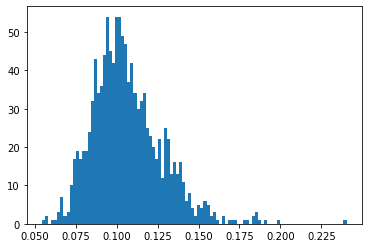

80.84 ['81.01']

group =  2
80.84 ['81.10', '81.01']

group =  3
80.84 ['81.43', '81.52', '81.43']


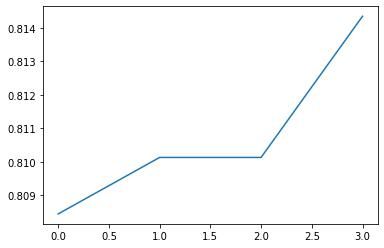

In [43]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
dists_az_fi, X_target_groups_az_fi = gradual_train_groups(az2000[:1185], y_train_az[:1185], fi2000[:data_size], y_train_fi[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 3], conf = 0)


group =  1


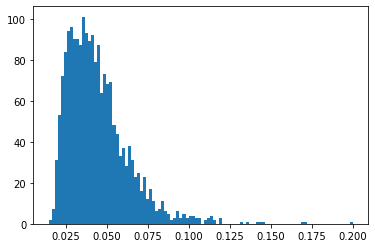

85.50 ['85.25']


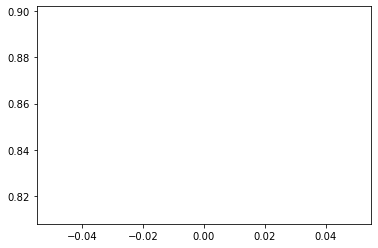

In [33]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(tw3000[:data_size], y_train_tw[:data_size], tw3000[:data_size], y_train_tw[:data_size], 
                         base_model, data_size=data_size, group_range=[0, 1, 2], conf = 0)


group =  1


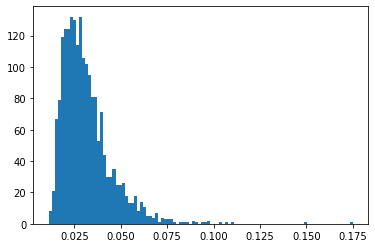

90.95 ['90.95']

group =  2
90.95 ['90.45', '90.45']


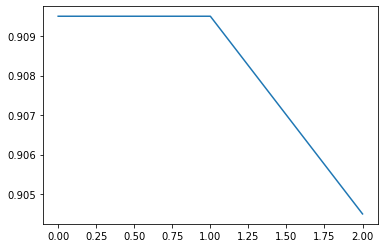

In [51]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(mv3000[:data_size], y_train_mv[:data_size], mv3000[:data_size], y_train_mv[:data_size], 
                         base_model, data_size=data_size, group_range=[0, 2], conf = 0)


group =  1


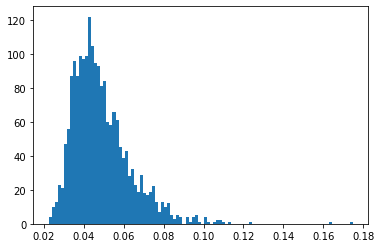

81.75 ['81.55']

group =  2
81.75 ['81.95', '81.50']

group =  3
81.75 ['82.00', '81.70', '81.00']

group =  4
81.75 ['82.15', '81.50', '81.25', '80.90']

group =  5
81.75 ['82.15', '81.30', '80.95', '80.80', '80.55']

group =  6
81.75 ['82.05', '81.45', '80.95', '80.50', '80.30', '80.00']

group =  7
81.75 ['81.75', '81.60', '80.85', '80.50', '80.35', '80.20', '79.75']

group =  8
81.75 ['81.70', '81.60', '80.85', '80.20', '80.15', '79.75', '79.55', '79.65']

group =  9
81.75 ['81.90', '81.65', '80.85', '80.40', '80.35', '79.85', '79.40', '79.50', '79.45']

group =  10
81.75 ['81.95', '81.65', '81.50', '80.85', '80.15', '80.45', '80.20', '80.10', '80.05', '79.80']

group =  11
81.75 ['81.70', '81.65', '81.55', '80.65', '80.15', '79.95', '79.85', '79.35', '79.25', '79.00', '79.05']

group =  12
81.75 ['81.45', '81.55', '81.25', '80.55', '80.10', '79.60', '79.85', '79.40', '78.85', '78.70', '78.80', '78.60']

group =  13
81.75 ['81.80', '81.15', '81.20', '80.55', '80.50', '79.30', '79.3

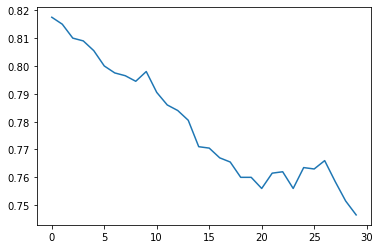

In [644]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_mv[:data_size], y_train_mv[:data_size], 
                                      base_model, data_size=data_size, group_range=[0, 30], conf = 0.1)


group =  1


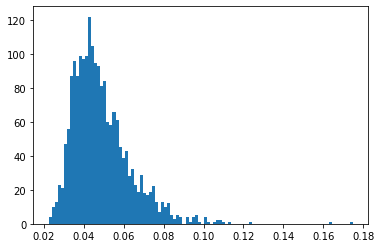

81.75 ['81.50']

group =  2
81.75 ['82.00', '81.95']

group =  3
81.75 ['81.85', '81.25', '81.10']

group =  4
81.75 ['82.55', '81.75', '81.40', '81.20']

group =  5
81.75 ['82.15', '81.60', '81.45', '81.50', '81.35']

group =  6
81.75 ['82.05', '81.50', '81.05', '81.05', '81.10', '81.10']

group =  7
81.75 ['82.35', '81.75', '81.85', '81.65', '81.70', '81.70', '81.55']

group =  8
81.75 ['82.05', '81.10', '81.10', '80.75', '80.60', '80.75', '81.00', '80.90']

group =  9
81.75 ['82.10', '81.85', '81.65', '81.65', '81.45', '81.15', '81.35', '81.40', '81.40']

group =  10
81.75 ['81.85', '81.60', '81.40', '81.70', '81.60', '81.65', '81.20', '81.30', '81.25', '81.25']

group =  11
81.75 ['81.65', '81.35', '80.90', '80.65', '80.50', '80.40', '80.40', '80.70', '80.55', '80.20', '80.40']

group =  12
81.75 ['81.60', '81.60', '80.45', '80.30', '80.15', '79.75', '80.00', '79.75', '79.40', '79.45', '79.45', '79.40']

group =  13
81.75 ['81.50', '81.30', '80.65', '80.15', '80.10', '79.30', '79.7

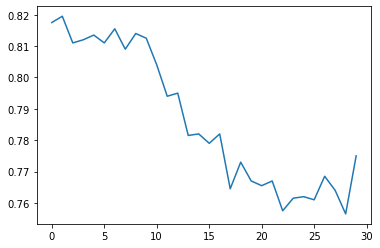

In [645]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
dists_az_mv, X_target_groups_az_mv = gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_mv[:data_size], y_train_mv[:data_size], 
                                      base_model, data_size=data_size, group_range=[0, 30], conf = 0)


group =  1


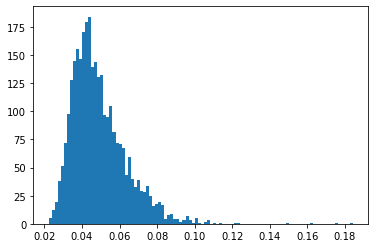

81.30 ['81.40']

group =  2
81.30 ['81.50', '80.87']

group =  3
81.30 ['81.70', '81.53', '81.00']

group =  4
81.30 ['81.87', '81.50', '81.27', '80.97']

group =  5
81.30 ['82.17', '81.40', '80.83', '80.73', '80.47']

group =  6
81.30 ['82.00', '81.93', '80.93', '80.87', '80.93', '80.63']

group =  7
81.30 ['81.93', '81.73', '80.90', '80.47', '80.53', '80.30', '80.40']

group =  8
81.30 ['81.83', '81.27', '80.70', '80.17', '80.33', '80.10', '79.57', '79.40']

group =  9
81.30 ['81.93', '81.63', '81.27', '80.53', '80.47', '80.13', '79.97', '79.73', '79.63']

group =  10
81.30 ['82.10', '81.50', '81.40', '80.63', '80.20', '80.40', '80.20', '79.80', '79.57', '79.37']

group =  11
81.30 ['81.83', '81.40', '80.87', '80.67', '79.77', '80.13', '79.87', '79.57', '79.50', '79.20', '79.20']

group =  12
81.30 ['81.87', '81.20', '80.57', '80.40', '79.97', '79.43', '79.77', '79.43', '78.77', '79.10', '78.90', '78.90']

group =  13
81.30 ['81.80', '81.20', '80.97', '80.43', '79.87', '79.03', '79.4

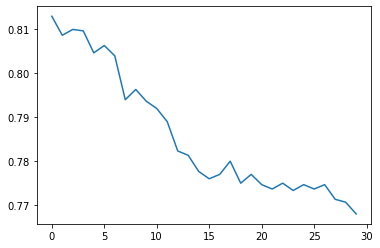

In [653]:
data_size = 3000
base_model = LogisticRegression(max_iter = 200000)
_  = gradual_train_groups(az3000[:data_size], y_train_az[:data_size], mv3000[:data_size], y_train_mv[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0.1)


group =  1


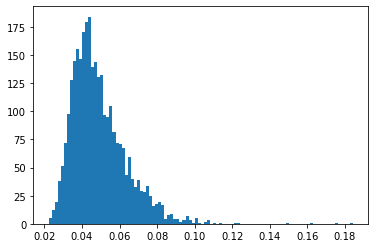

81.30 ['81.67']

group =  2
81.30 ['81.20', '80.97']

group =  3
81.30 ['81.60', '81.17', '81.03']

group =  4
81.30 ['81.80', '81.43', '81.43', '81.33']

group =  5
81.30 ['81.73', '81.57', '81.03', '80.93', '80.93']

group =  6
81.30 ['81.93', '82.23', '81.27', '81.40', '80.87', '80.77']

group =  7
81.30 ['81.63', '81.67', '81.07', '80.90', '80.77', '80.70', '80.57']

group =  8
81.30 ['81.70', '81.50', '81.03', '80.47', '80.83', '80.50', '80.47', '80.43']

group =  9
81.30 ['81.97', '82.00', '81.70', '81.00', '81.40', '81.07', '80.83', '80.67', '80.80']

group =  10
81.30 ['82.13', '82.13', '82.20', '81.80', '81.37', '81.37', '81.20', '80.63', '80.47', '80.57']

group =  11
81.30 ['81.97', '82.10', '81.60', '81.53', '80.77', '80.67', '80.73', '80.67', '80.40', '80.37', '80.37']

group =  12
81.30 ['82.00', '82.00', '81.97', '81.57', '80.97', '80.57', '80.90', '80.77', '80.93', '80.77', '80.73', '80.67']

group =  13
81.30 ['82.23', '81.80', '81.60', '81.70', '80.90', '80.63', '80.6

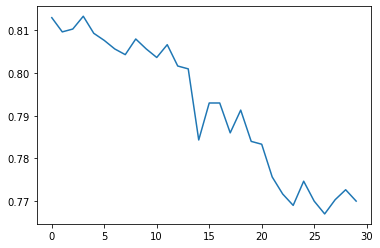

In [654]:
data_size = 3000
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(az3000[:data_size], y_train_az[:data_size], mv3000[:data_size], y_train_mv[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0)


group =  1


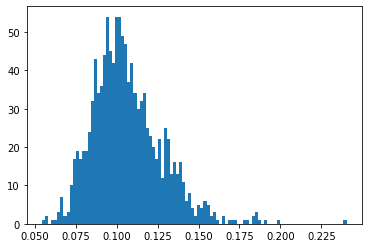

80.84 ['81.27']

group =  2
80.84 ['81.27', '80.93']

group =  3
80.84 ['81.60', '81.86', '81.27']

group =  4
80.84 ['81.43', '81.10', '81.77', '81.01']

group =  5
80.84 ['81.69', '81.35', '81.43', '81.35', '81.27']

group =  6
80.84 ['81.69', '81.43', '81.10', '81.35', '81.27', '81.18']

group =  7
80.84 ['81.77', '80.68', '81.52', '81.01', '80.93', '80.76', '80.42']

group =  8
80.84 ['81.69', '81.10', '81.69', '81.69', '81.94', '82.19', '81.69', '81.43']

group =  9
80.84 ['81.43', '82.03', '82.03', '82.19', '82.62', '82.45', '82.70', '82.19', '82.28']

group =  10
80.84 ['81.18', '82.28', '81.60', '81.52', '81.43', '81.60', '81.94', '81.94', '82.11', '81.86']

group =  11
80.84 ['80.51', '81.86', '81.52', '81.43', '81.52', '81.10', '81.86', '81.94', '81.60', '80.93', '80.93']

group =  12
80.84 ['80.76', '81.52', '81.60', '81.94', '81.43', '81.35', '81.60', '81.35', '81.43', '81.77', '81.52', '81.27']

group =  13
80.84 ['81.52', '81.60', '81.86', '81.94', '81.60', '81.52', '81.6

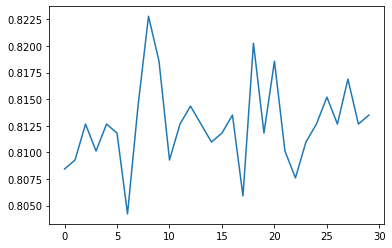

In [648]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_fi[:data_size], y_train_fi[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0.1)


group =  1


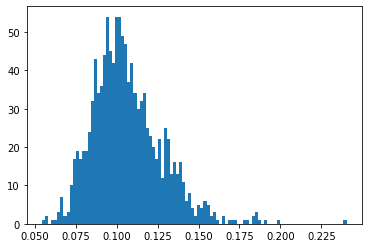

80.84 ['81.01']

group =  2
80.84 ['81.10', '81.01']

group =  3
80.84 ['81.43', '81.52', '81.43']

group =  4
80.84 ['80.59', '80.34', '80.25', '80.34']

group =  5
80.84 ['80.93', '80.34', '80.59', '80.51', '80.51']

group =  6
80.84 ['81.10', '80.68', '80.42', '80.34', '80.25', '80.25']

group =  7
80.84 ['80.84', '81.27', '81.43', '81.10', '81.18', '81.18', '81.27']

group =  8
80.84 ['81.01', '80.59', '81.27', '80.68', '81.01', '81.35', '81.27', '81.35']

group =  9
80.84 ['81.10', '81.01', '81.35', '81.01', '81.10', '81.01', '80.93', '80.76', '80.76']

group =  10
80.84 ['80.42', '80.93', '80.93', '80.76', '80.93', '81.27', '81.35', '81.27', '81.27', '81.27']

group =  11
80.84 ['80.51', '81.18', '80.42', '80.76', '80.51', '80.51', '80.51', '80.76', '80.51', '80.25', '80.25']

group =  12
80.84 ['80.34', '80.84', '80.84', '81.35', '80.84', '80.84', '81.01', '80.59', '80.68', '80.76', '80.76', '80.76']

group =  13
80.84 ['80.51', '80.42', '80.42', '81.10', '80.84', '80.59', '80.6

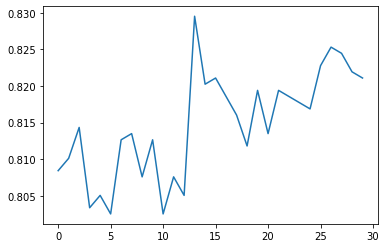

In [649]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
dists_az_fi, X_target_groups_az_fi = gradual_train_groups(output_train_az[:data_size], y_train_az[:data_size], output_train_fi[:data_size], y_train_fi[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0)


group =  1


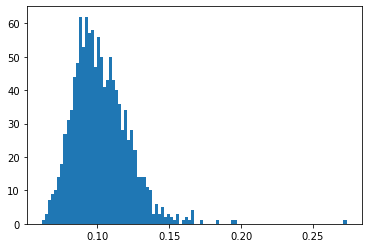

79.24 ['80.17']

group =  2
79.24 ['80.00', '80.17']

group =  3
79.24 ['80.08', '80.08', '79.83']

group =  4
79.24 ['79.58', '80.25', '80.34', '80.17']

group =  5
79.24 ['79.41', '80.08', '80.42', '80.08', '80.25']

group =  6
79.24 ['79.24', '79.24', '79.16', '79.32', '79.41', '79.58']

group =  7
79.24 ['79.66', '80.25', '81.10', '81.27', '81.18', '80.93', '81.01']

group =  8
79.24 ['78.31', '79.66', '78.90', '79.24', '79.49', '79.41', '79.24', '79.24']

group =  9
79.24 ['79.16', '79.92', '80.51', '80.68', '80.59', '81.01', '80.76', '80.84', '80.93']

group =  10
79.24 ['78.57', '80.59', '81.86', '81.86', '81.60', '82.03', '82.19', '81.86', '82.28', '82.03']

group =  11
79.24 ['79.32', '80.76', '82.03', '81.77', '82.19', '81.94', '82.11', '82.03', '81.52', '81.27', '81.52']

group =  12
79.24 ['80.08', '81.18', '81.94', '82.11', '82.53', '82.19', '82.70', '82.70', '82.78', '82.87', '82.87', '82.78']

group =  13
79.24 ['80.34', '81.60', '82.11', '82.36', '81.94', '82.53', '82.5

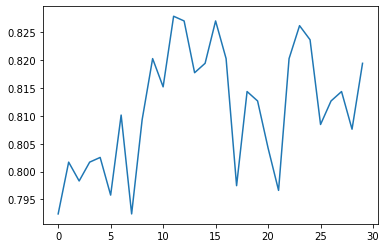

In [655]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(output_train_fi[:data_size], y_train_fi[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0.1)


group =  1


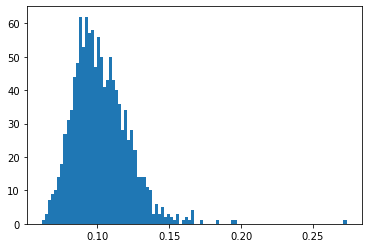

79.24 ['79.32']

group =  2
79.24 ['80.00', '80.08']

group =  3
79.24 ['80.59', '80.51', '80.59']

group =  4
79.24 ['80.76', '80.42', '80.68', '80.68']

group =  5
79.24 ['79.66', '79.58', '79.49', '79.75', '79.75']

group =  6
79.24 ['78.90', '78.65', '79.07', '78.99', '78.90', '78.73']

group =  7
79.24 ['79.24', '78.90', '79.24', '79.49', '79.49', '79.49', '79.49']

group =  8
79.24 ['78.06', '78.90', '78.73', '78.48', '78.57', '78.48', '78.48', '78.57']

group =  9
79.24 ['79.66', '80.17', '80.42', '80.17', '80.08', '80.17', '80.17', '80.25', '80.25']

group =  10
79.24 ['79.24', '80.00', '80.42', '80.34', '80.42', '80.59', '80.68', '80.68', '80.59', '80.68']

group =  11
79.24 ['79.16', '80.51', '80.93', '81.35', '81.43', '81.69', '81.52', '81.77', '81.52', '81.60', '81.60']

group =  12
79.24 ['79.49', '80.59', '80.68', '80.17', '80.42', '80.51', '80.59', '80.68', '80.84', '80.84', '80.84', '80.84']

group =  13
79.24 ['80.00', '80.93', '81.01', '81.52', '81.27', '81.27', '81.1

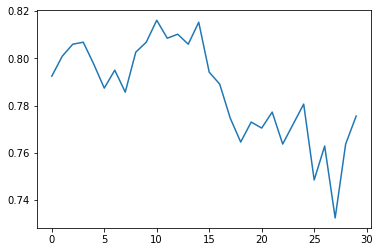

In [ ]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
dists_fi_az, X_target_groups_fi_az = gradual_train_groups(output_train_fi[:data_size], y_train_fi[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0)


group =  1


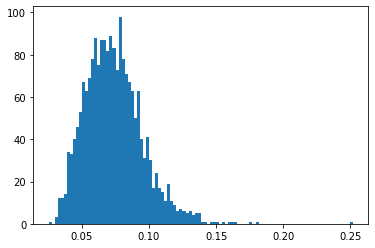

78.55 ['79.20']

group =  2
78.55 ['78.45', '78.65']

group =  3
78.55 ['78.40', '78.65', '78.70']

group =  4
78.55 ['78.65', '78.45', '78.40', '78.10']

group =  5
78.55 ['77.75', '77.40', '77.15', '77.65', '77.10']

group =  6
78.55 ['78.05', '78.45', '77.85', '77.70', '77.90', '77.75']

group =  7
78.55 ['78.30', '78.65', '77.90', '78.10', '78.40', '78.10', '78.10']

group =  8
78.55 ['78.00', '78.20', '77.80', '78.00', '77.80', '77.60', '77.70', '77.40']

group =  9
78.55 ['77.35', '77.70', '77.65', '76.90', '76.95', '77.00', '77.25', '77.20', '76.75']

group =  10
78.55 ['76.90', '76.70', '76.95', '76.40', '76.50', '76.35', '76.00', '76.30', '76.05', '76.05']

group =  11
78.55 ['77.70', '77.20', '77.45', '76.90', '76.40', '76.50', '76.50', '76.30', '76.45', '76.20', '76.20']

group =  12
78.55 ['77.80', '77.45', '77.30', '76.95', '76.70', '76.40', '76.15', '76.45', '76.20', '76.40', '76.15', '76.20']

group =  13
78.55 ['78.05', '77.75', '78.05', '78.40', '78.45', '77.90', '77.7

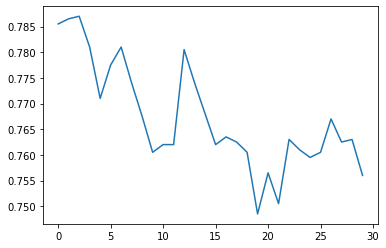

In [656]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
_ = gradual_train_groups(output_train_tw[:data_size], y_train_tw[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 30], conf = 0.1)


group =  1


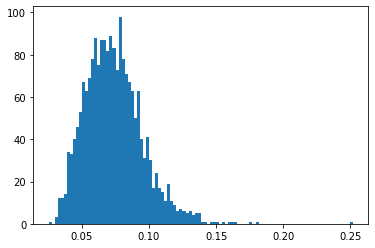

78.55 ['78.75']

group =  2
78.55 ['78.30', '78.45']

group =  3
78.55 ['78.20', '78.20', '78.40']

group =  4
78.55 ['78.20', '78.45', '78.45', '78.50']

group =  5
78.55 ['77.55', '77.35', '77.45', '77.30', '77.25']

group =  6
78.55 ['77.30', '77.45', '77.15', '76.95', '76.95', '76.95']

group =  7
78.55 ['77.95', '78.35', '78.25', '78.20', '78.45', '78.40', '78.35']

group =  8
78.55 ['77.90', '77.70', '77.45', '77.40', '77.20', '76.95', '76.95', '76.95']

group =  9
78.55 ['77.95', '78.10', '77.50', '77.65', '77.60', '77.95', '77.45', '77.40', '77.55']

group =  10
78.55 ['77.75', '77.65', '77.70', '77.55', '77.25', '77.15', '77.10', '77.25', '77.15', '77.30']


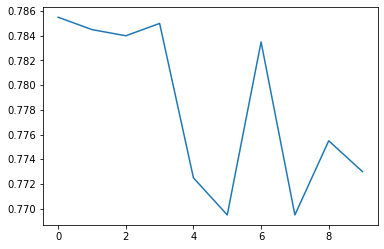

In [621]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
dists_tw_az = gradual_train_groups(output_train_tw[:data_size], y_train_tw[:data_size], output_train_az[:data_size], y_train_az[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 10], conf = 0)


group =  1


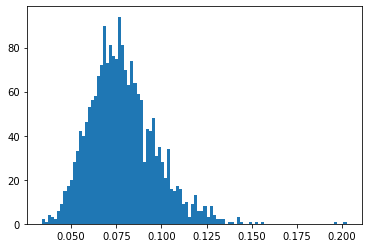

71.40 ['71.10']

group =  2
71.40 ['71.95', '71.95']

group =  3
71.40 ['72.00', '72.20', '71.90']


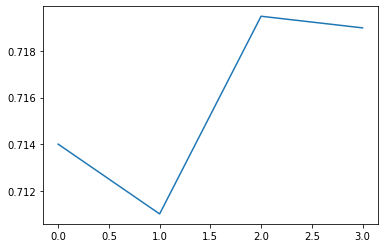

In [44]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
dists_tw_az = gradual_train_groups(tw2000[:data_size], y_train_tw[:data_size], mv2000[:data_size], y_train_mv[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 3], conf = 0)


group =  1


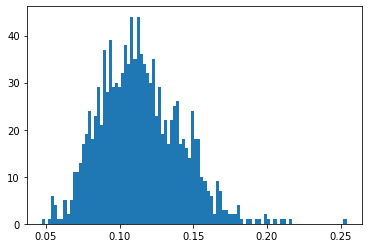

67.51 ['67.59']

group =  2
67.51 ['67.17', '67.59']

group =  3
67.51 ['68.44', '68.52', '68.61']


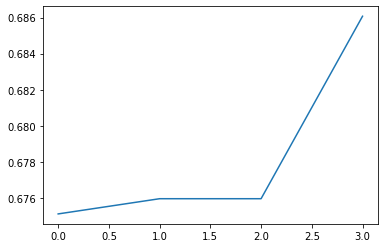

In [47]:
data_size = 1185
base_model = LogisticRegression(max_iter = 200000)
dists_tw_az = gradual_train_groups(tw2000[:data_size], y_train_tw[:data_size], fi2000[:1185], y_train_fi[:1185], 
                     base_model, data_size=data_size, group_range=[0, 3], conf = 0)


group =  1


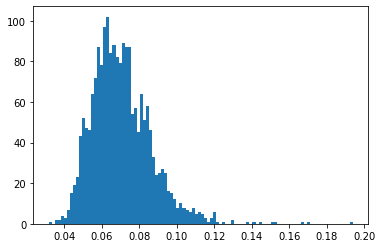

68.95 ['68.30']

group =  2
68.95 ['68.55', '68.55']

group =  3
68.95 ['68.60', '68.55', '68.60']


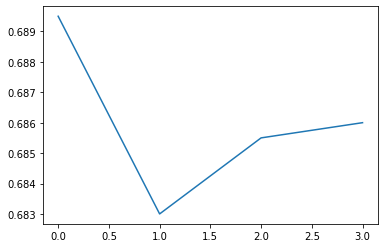

In [49]:
data_size = 2000
base_model = LogisticRegression(max_iter = 200000)
dists_tw_az = gradual_train_groups(az2000[:data_size], y_train_az[:data_size], tw2000[:data_size], y_train_tw[:data_size], 
                     base_model, data_size=data_size, group_range=[0, 3], conf = 0)

### explore confidence and sample weights

In [539]:
lr = LogisticRegression(max_iter = 200000)
lr.fit(output_train_az, y_train_az[:2000])
probs = lr.predict_proba(output_train_az)

In [563]:
single_probs = probs[:,0]

In [579]:
len(single_probs[(single_probs>0.5) | (single_probs<=0.5) ])

2000

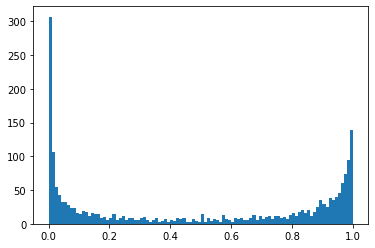

In [564]:
plt.hist(single_probs, bins=100)
plt.show()

### explore distribution of bert measures

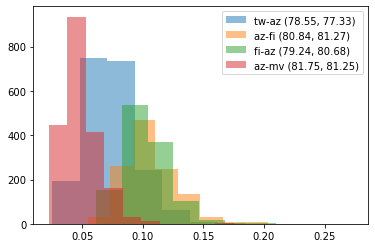

In [633]:
plt.hist(dists_tw_az, alpha=0.5) # t = 5 conf = 0
plt.hist(dists_az_fi, alpha=0.5)
plt.hist(dists_fi_az, alpha=0.5)
plt.hist(dists_az_mv, alpha=0.5)
plt.legend(["tw-az (78.55, 77.33)", "az-fi (80.84, 81.27)", "fi-az (79.24, 80.68)","az-mv (81.75, 81.25)"])
plt.show()

In [14]:
# import matplotlib.pyplot as plt
# plt.hist(dists_tw_az, alpha=0.5, density = True) # t = 5 conf = 0
# plt.hist(dists_az_fi, alpha=0.5, density = True)
# plt.hist(dists_fi_az, alpha=0.5, density = True)
# plt.hist(dists_az_mv, alpha=0.5, density = True)
# plt.legend(["tw-az (78.55, 77.33)", "az-fi (80.84, 81.27)", "fi-az (79.24, 80.68)","az-mv (81.75, 81.25)"])
# plt.show()

### Data to pickle

In [617]:
# all_bert_zip = zipfile.ZipFile(data_path + 'all_bert.zip')
# with open('/Users/yuchen.zhang/Documents/Projects/domain-adaptation-nlp/data/bert_2000_3000.pickle', 'wb') as f:
#     pickle.dump(all_bert_zip, f)

## checking v1

In [395]:
az_bert = np.mean(output_train_az,0)
dists = []
for e in output_train_mv:
    dist = 1- cosine_similarity(az_bert.reshape(1, -1), e.reshape(1, -1))[0][0]
    dists.append(dist)

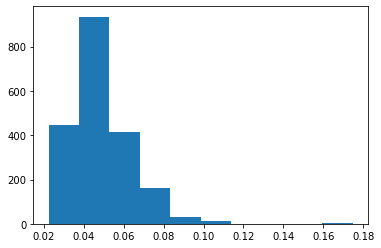

In [396]:
plt.hist(dists)
plt.show()

In [412]:
dists = np.array(dists)
dists_order = np.argsort(dists)
dists_rank = np.argsort(dists_order)

step = 2000/5
target_x = []
target_y = []

for i in range(5):
    subset_tf = (step*i <= dists_rank) & (dists_rank < step* (i+1))
    t_x = output_train_mv[subset_tf]
    t_y = y_train_mv[:2000][subset_tf]
    target_x.append(t_x)
    target_y.append(t_y)
    
print(dists_rank[892])
print(dists[892])

0
0.02226760322709498


In [444]:
lr = LogisticRegression(max_iter = 200000)
lr.fit(output_train_az, y_train_az[:2000])
print("Train:")
print(lr.score(output_train_az, y_train_az[:2000]), "\n")
print("Val:")
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[0])
X_train_az_t1 = np.concatenate((output_train_az, target_x[0]), 0)
y_train_az_t1 = np.concatenate((y_train_az[:2000], y_pred), 0)
lr.fit(X_train_az_t1, y_train_az_t1)
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[1])
X_train_az_t1t2 = np.concatenate((X_train_az_t1, target_x[1]), 0)
y_train_az_t1t2 = np.concatenate((y_train_az_t1, y_pred), 0)
lr.fit(X_train_az_t1t2, y_train_az_t1t2)
print(lr.score(output_train_mv, y_train_mv[:2000]))

y_pred = lr.predict(target_x[2])
X_train_az_t1t2t3 = np.concatenate((X_train_az_t1t2, target_x[2]), 0)
y_train_az_t1t2t3 = np.concatenate((y_train_az_t1t2, y_pred), 0)
lr.fit(X_train_az_t1t2t3, y_train_az_t1t2t3)
print(lr.score(output_train_mv, y_train_mv[:2000]))

y_pred = lr.predict(target_x[3])
X_train_az_t1t2t3t4 = np.concatenate((X_train_az_t1t2t3, target_x[3]), 0)
y_train_az_t1t2t3t4 = np.concatenate((y_train_az_t1t2t3, y_pred), 0)
lr.fit(X_train_az_t1t2t3t4, y_train_az_t1t2t3t4)
print(lr.score(output_train_mv, y_train_mv[:2000]))


y_pred = lr.predict(target_x[4])
X_train_az_t1t2t3t4t5 = np.concatenate((X_train_az_t1t2t3t4, target_x[4]), 0)
y_train_az_t1t2t3t4t5 = np.concatenate((y_train_az_t1t2t3t4, y_pred), 0)
lr.fit(X_train_az_t1t2t3t4t5, y_train_az_t1t2t3t4t5)
print(lr.score(output_train_mv, y_train_mv[:2000]))

Train:
0.9315 

Val:
0.8175
0.8215
0.816
0.8145
0.815
0.8135


## checking v2

In [430]:
# from Young-Min with some edits

def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression(max_iter = 200000) #edited 
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)

def cos_dist(A, B):
       return 1 - (np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B)))
    
def S2ti(train_features, train_labels, test_features, test_labels):
    print("train.shape: ",train_labels.shape)
    print("test.shape: ",test_labels.shape)    
    source_center = np.mean(train_features, 0)
    target_distances = [1-cosine_similarity(source_center.reshape(1,-1), x.reshape(1, -1))[0][0] for x in test_features] #edited
    print("histogram of distance:")
    plt.hist(target_distances)
    plt.show()
    target_distances = [(i,x) for i,x in enumerate(target_distances)]
    target_distances = sorted(target_distances, key=lambda x: x[1])
    one_fifth = int(len(target_distances)/5)
    target_1in5 = target_distances[:one_fifth]
    target_2in5 = target_distances[one_fifth:2*one_fifth]
    target_3in5 = target_distances[2*one_fifth:3*one_fifth]
    target_4in5 = target_distances[3*one_fifth:4*one_fifth]
    target_5in5 = target_distances[4*one_fifth:]
    X_train = train_features[:]
    y_train = train_labels[:]
    y_pred_store = []
    y_test_store = []
    for target in [target_1in5,target_2in5,target_3in5,target_4in5,target_5in5]:
        X_test = [test_features[i] for i,x in target]
        y_test = [test_labels[i] for i,x in target]
        lr_clf = LogisticRegression(max_iter = 200000) #edited 
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        X_train = np.concatenate((X_train, X_test), axis=0)
        y_train = np.concatenate((y_train, y_pred), axis=0)
        y_pred_store += y_pred.tolist()
        y_test_store += y_test
    output_score = [y_pred_store[i]==y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score)/len(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    return original_score, gradual_score

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


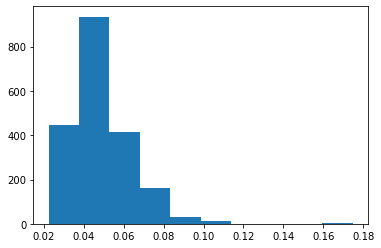

(0.8175, 0.813)

In [431]:
S2ti(output_train_az, np.array(y_train_az[:2000]), 
     output_train_mv, np.array(y_train_mv[:2000]))

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


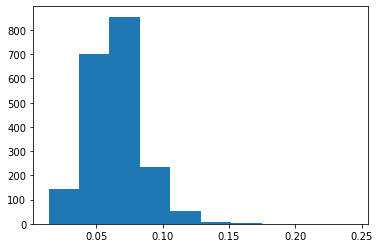

(0.854, 0.8485)

In [663]:
S2ti(output_train_mv, np.array(y_train_mv[:2000]), 
     output_train_az, np.array(y_train_az[:2000]))

train.shape:  (2000,)
test.shape:  (2000,)
histogram of distance:


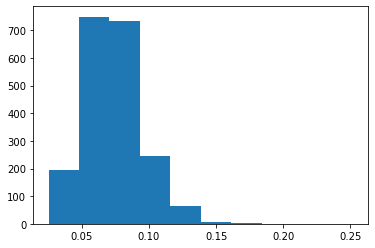

(0.7855, 0.7745)

In [664]:
S2ti(output_train_tw, np.array(y_train_tw[:2000]), 
     output_train_az, np.array(y_train_az[:2000]))

train.shape:  (1185,)
test.shape:  (1185,)
histogram of distance:


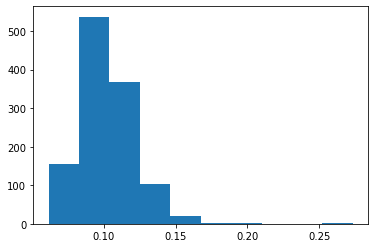

(0.7924050632911392, 0.7949367088607595)

In [666]:
S2ti(output_train_fi, np.array(y_train_fi[:1185]), 
     output_train_az[:1185], np.array(y_train_az[:1185]))

train.shape:  (1185,)
test.shape:  (2000,)
histogram of distance:


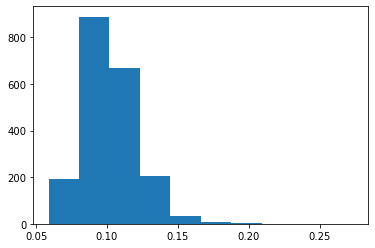

(0.7985, 0.8055)

In [667]:
S2ti(output_train_fi, np.array(y_train_fi[:2000]), 
     output_train_az, np.array(y_train_az[:2000]))

train.shape:  (2000,)
test.shape:  (1185,)
histogram of distance:


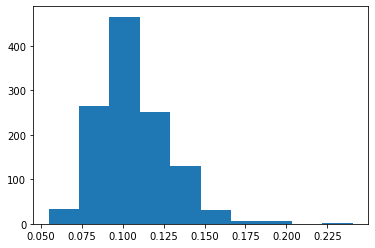

(0.7932489451476793, 0.809282700421941)

In [668]:
S2ti(output_train_az, np.array(y_train_az[:2000]), 
     output_train_fi, np.array(y_train_fi[:2000]))

train.shape:  (2000,)
test.shape:  (1185,)
histogram of distance:


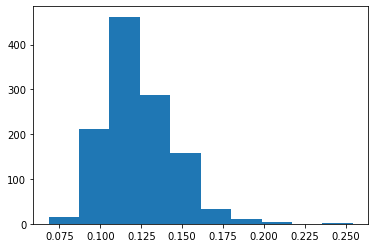

(0.760337552742616, 0.7586497890295358)

In [669]:
S2ti(output_train_mv, np.array(y_train_mv[:2000]), 
     output_train_fi, np.array(y_train_fi[:2000]))

train.shape:  (1185,)
test.shape:  (2000,)
histogram of distance:


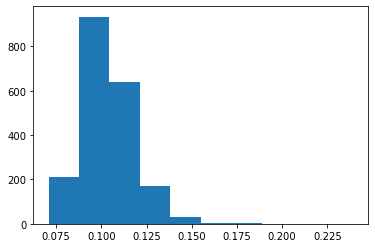

(0.774, 0.779)

In [670]:
S2ti(output_train_fi, np.array(y_train_fi[:2000]), 
     output_train_mv, np.array(y_train_mv[:2000]))

# compare versions

In [25]:
def psuedo_labeling_label_final(x_s, y_s, x_t, y_t, model, conf):
    # TODO: add NER version; NER version inputs are dictionaries
    base_model = model
    model.fit(x_s, y_s)
    y_prob = base_model.predict_proba(x_t)[:, 0]
    x_ti_keep = []
    x_ti_not_keep = []
    y_ti_keep = []
    y_ti_not_keep = []

    # if no data past the conf requirement, lower the requirement by 0.1
    while len(x_ti_keep) == 0:
        keep_ti_bool = (y_prob >= 0.5 + conf) | (y_prob < 0.5 - conf)
        x_ti_keep = x_t[keep_ti_bool]
        x_ti_not_keep = x_t[~keep_ti_bool]
        y_ti_keep = y_t[keep_ti_bool]
        y_ti_not_keep = y_t[~keep_ti_bool]
        conf = conf - 0.01
    print(conf)

    # output prediction and update source
    y_pred = model.predict(x_ti_keep)
    x_source_updated = np.concatenate((x_s, x_ti_keep), 0)
    y_source_updated = np.concatenate((y_s, y_pred), 0)
    print(len(x_ti_not_keep))
    return x_source_updated, y_source_updated, y_pred, y_ti_keep, x_ti_not_keep, y_ti_not_keep


def gradual_train_conf_groups(x_source_raw, y_source_raw, x_target_raw, y_target_raw, base_model, data_size, conf):
    # initiate values
    data_size = min(len(x_source_raw), len(x_target_raw), data_size)
    print(data_size)
    x_source_raw, y_source_raw = x_source_raw[:data_size], y_source_raw[:data_size]
    x_target_raw, y_target_raw = x_target_raw[:data_size], y_target_raw[:data_size]
    print(x_source_raw.shape, y_source_raw.shape, x_target_raw.shape, y_target_raw.shape)

    x_source, y_source = x_source_raw, y_source_raw
    x_target, y_target = x_target_raw, y_target_raw
    y_pred_all = []
    y_true_all = []

    # repeat self-train until all target data are computed
    while len(x_target) > 0:
        x_source, y_source, y_pred, y_true, x_target, y_target = psuedo_labeling_label_final(
            x_source, y_source, x_target, y_target, base_model, conf
        )
        y_pred_all.extend(list(y_pred))
        y_true_all.extend(list(y_true))

    # calculate accuracy
    s2t_score = base_model.fit(x_source_raw, y_source_raw).score(x_target_raw, y_target_raw)
    s2s_score = base_model.fit(x_source_raw, y_source_raw).score(x_source_raw, y_source_raw)
    t2t_score = base_model.fit(x_target_raw, y_target_raw).score(x_target_raw, y_target_raw)
    gradual_score = accuracy_score(y_true_all, y_pred_all)
    return s2s_score, t2t_score, s2t_score, gradual_score

In [ ]:
def S2T_prob_4_adj(train_features, train_labels, test_features, test_labels, base_model):
    # gradual training
    X_train = train_features[:]
    y_train = train_labels[:]
    X_test = test_features[:]
    y_test = test_labels[:]
    y_pred_store = []
    y_test_store = []
    previous_r_target = []
    while len(X_test) > 0:
        lr_clf = base_model
        lr_clf.fit(X_train, y_train)
        y_pred = lr_clf.predict(X_test)
        y_prob = lr_clf.predict_proba(X_test)[:, 0]
        keep_index = []
        not_keep_index = None
        conf = 0.4
        while len(keep_index) == 0 and conf >= 0:
            keep_index = [i for i, val in enumerate(y_prob) if (val >= 0.5 + conf) or (val < 0.5 - conf)]
            not_keep_index = [i for i, val in enumerate(y_prob) if (val < 0.5 + conf) and (val >= 0.5 - conf)]
            conf = conf - 0.01
        if len(keep_index) == 0:
            keep_index = [i for i, val in enumerate(y_prob)]
            not_keep_index = []
        X_test_keep = [X_test[i] for i in keep_index]
        print(len(X_test_keep))
        y_pred_keep = [y_pred[i] for i in keep_index]
        X_train = np.concatenate((X_train, X_test_keep), axis=0)
        y_train = np.concatenate((y_train, y_pred_keep), axis=0)
        y_pred_store += y_pred_keep
        y_test_store += [y_test[i] for i in keep_index]
        X_test = [X_test[i] for i in not_keep_index]
        y_test = [y_pred[i] for i in not_keep_index]
        if X_test == previous_r_target:
            break
        previous_r_target = X_test[:]
    if len(y_pred_store) != len(test_labels):
        raise ValueError('output dimension error!')
    output_score = [y_pred_store[i] == y_test_store[i] for i in range(len(y_test_store))]
    gradual_score = sum(output_score) / len(output_score)
    print(output_score)
    original_score = S2T(train_features, train_labels, test_features, test_labels)
    lr_clf = LogisticRegression()
    lr_clf.fit(X_train, y_train)
    y_pred = lr_clf.predict(test_features)
    lm_score = [y_pred[i] == y_test_store[i] for i in range(len(y_test_store))]
    lm_score = sum(lm_score) / len(lm_score)

    return original_score, lm_score, gradual_score

In [9]:
def load_bert(data_path, domains, data_size):
    bert_dataset = {}
    for domain in domains:
        bert_dataset[domain] = np.load(data_path + "all_bert/encoded_" +
                                       domain + "_train_" + str(data_size) + ".npy")
    return bert_dataset

def load_np_files(data_path, domains, data_types, load_feature):
    np_dataset = {}
    for domain in domains:
        for data_type in data_types:
            if load_feature:
                file_prefix = "X_"
            else:
                file_prefix = "y_"
            file = file_prefix + data_type + "_" + domain
            filename = data_path + "all_cleaned/" + file + ".npy"
            np_dataset[file] = np.load(filename, allow_pickle=True)
    return np_dataset

In [10]:
import numpy as np
data_path = "../data/"
domains = ["tw", "az", "mv", "fi"]

# Load data.

bert_dict = load_bert(data_path, domains, 2000)
y_dict = load_np_files(data_path, domains, ['train', 'dev'], load_feature=False)
for b in bert_dict:
    print(b, len(bert_dict[b]))
for y in y_dict:
    print(y, len(y_dict[y]))

tw 2000
az 2000
mv 2000
fi 1185
y_train_tw 718240
y_dev_tw 353760
y_train_az 2412000
y_dev_az 1188000
y_train_mv 40000
y_dev_mv 5000
y_train_fi 1185
y_dev_fi 132


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
x_source_example = bert_dict['tw']
x_target_example = bert_dict['az']
y_source_example = y_dict['y_train_tw']
y_target_example = y_dict['y_train_az']
base_model = LogisticRegression(max_iter=2000)
data_size = 2000
conf = 0.4

gradual_train_conf_groups(x_source_example, y_source_example, x_target_example, y_target_example, base_model, data_size, conf)

2000
(2000, 768) (2000,) (2000, 768) (2000,)
0.39
1121
0.39
895
0.39
814
0.39
774
0.39
755
0.39
746
0.39
742
0.39
738
0.39
737
0.39
736
0.39
0.38
714
0.39
0.38
709
0.39
0.38
704
0.39
0.38
702
0.39
0.38
0.37
681
0.39
0.38
0.37
673
0.39
0.38
0.37
669
0.39
0.38
0.37
668
0.39
0.38
0.37
666
0.39
0.38
0.37
665
0.39
0.38
0.37
663
0.39
0.38
0.37
662
0.39
0.38
0.37
660
0.39
0.38
0.37
659
0.39
0.38
0.37
658
0.39
0.38
0.37
0.36
641
0.39
0.38
0.37
0.36
629
0.39
0.38
0.37
626
0.39
0.38
0.37
625
0.39
0.38
0.37
0.36
619
0.39
0.38
0.37
0.36
615
0.39
0.38
0.37
0.36
613
0.39
0.38
0.37
0.36
610
0.39
0.38
0.37
0.36
607
0.39
0.38
0.37
0.36
604
0.39
0.38
0.37
0.36
600
0.39
0.38
0.37
0.36
598
0.39
0.38
0.37
0.36
597
0.39
0.38
0.37
0.36
0.35
588
0.39
0.38
0.37
0.36
0.35
585
0.39
0.38
0.37
0.36
0.35
576
0.39
0.38
0.37
0.36
0.35
572
0.39
0.38
0.37
0.36
0.35
569
0.39
0.38
0.37
0.36
0.35
566
0.39
0.38
0.37
0.36
0.35
565
0.39
0.38
0.37
0.36
0.35
0.33999999999999997
549
0.39
0.38
0.37
0.36
0.35
547
0.39
0.38
0.37
0

(0.8545, 0.9315, 0.7855, 0.728)

In [31]:
def S2T(train_features, train_labels, test_features, test_labels):
    lr_clf = LogisticRegression()
    lr_clf.fit(train_features, train_labels)
    return lr_clf.score(test_features, test_labels)

S2T_prob_4_adj(x_source_example, y_source_example[:2000], x_target_example, y_target_example[:2000], base_model)

/Users/yuchen.zhang/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yuchen.zhang/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

(0.78, 0.727, 0.9605)